# DQN on the CartPole problem

In this assignment you will implement the DQN algorithm to solve a classic control problem, the CartPole.

### The CartPole problem

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

<img src="https://drive.google.com/uc?export=download&id=1wiFksyB3-mcirfdZEvrT2DPD7SBEjye2" >
<img src="RL-final.png" >

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep as long as the position of the rod is correct (not inclined too far away from the vertical position).
The length of one episode is 200 time steps. Therefore the possible maximum score is 200.

The state is low dimensional and cosists of:
* position
* velocity
* angle
* angular velocity

Further details can be found on OpenAI gym's webpage: (https://gymnasium.farama.org/environments/classic_control/cart_pole/)

In [1]:
# Installs necessary in Colab
#!pip install gymnasium
#!pip install gymnasium[classic-control]

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import random
from enum import Enum
from skimage import transform as trf
from keras.models import Sequential # Keras: highlevel API above dnn libraries (tendorflow, cntr, theano)
from keras.layers import Dense, Convolution2D, Flatten
#from keras.optimizers import Adam, SGD, RMSprop
#Locally I need legacy due to m1 mac
from keras.optimizers.legacy import Adam, SGD, RMSprop 
from numpy.random import seed

In [3]:
class Optimizer(Enum): # Enum, Makes easier to try different optimizers
    ADAM = 1
    RMSPROP = 2
    SGD = 3

In [4]:
# The implementation of DQN.
class Dqn:

    def __init__(self, params):
        self.env = None                       # The environment where the RL agent will learn.
        self.buffer_size = params.buf_size    # The maximum size of the experience replay.
        self.batch_size = params.batch        # Batch size during training.
        self.epoch = params.epoch             # For one training cycle, the number epoch on a batch.
        self.max_episode = params.max_ep      # The number of episodes for training.
        self.eps0 = params.eps                # The starting value of epsilon in the epsilon-greedy policy.
        self.gamma = params.gamma             # Discounting factor.
        self.C = params.C                     # Frequency of synchronizing the frozen network.
        self.train_freq = params.train_freq   # Update frequency for the not frozen network.
        self.eval_freq = params.eval_freq     # Evaluation frequency.
        self.net = params.net                 # The description of the network. List of tuples. A tuple: (number of units, activation)
        self.lr = params.lr                   # learning rate
        self.opt = params.opt                 # Optimizer.

        self.q_cont, self.q_frzn = None, None # two networks for training: continuously updated and frozen

        self.buffer = []  # experience replay

        # v0 gives a warning and recommends upgrading, but I kept it as this implementation is optimized for it
        self.env = gym.make('CartPole-v0', render_mode="rgb_array" )

        self.env.reset(seed=1, options={})
        self.q_cont, self.q_frzn = self._init_models()

    # ------------------------------------------------------
    # functions for initialization

    def _init_optimizer(self):

        optz = None
        if self.opt == Optimizer.ADAM:
            optz = Adam(self.lr)
        elif self.opt == Optimizer.SGD:
            optz = SGD(self.lr)
        elif self.opt == Optimizer.RMSPROP:
            optz = RMSprop(self.lr)

        return optz

    # The network builds up from Dense layers (similar to the fully connected)
    def _init_models(self):

        def build(strc):
            # strc - list of tuples
            # each tuple contains: number of nodes in the dense layer, activation function name (e.g.: 'relu')
            # ----- implement this -----
            q = Sequential()  # ----- create a sequential model -----
            # ----- add a dense layer with input_shape 4 (4 frames will be stacked) -----
            # use the strc for accessing the required parameters
            q.add(Dense(strc[0][0], activation=strc[0][1], input_shape=(4,)))

            for i in range(1, len(strc)):
                # ----- add the remaining dense layers to the model
                q.add(Dense(strc[i][0], activation=strc[i][1]))


            optz = self._init_optimizer()
            # compile the model with an appropriate loss function
            q.compile(optimizer=optz, loss='mse')

            return q

        q_cont = build(self.net)  # continuously updated network (Q-function)
        q_frzn = build(self.net)  # frozen network

        q_cont.set_weights(q_frzn.get_weights())  # synchronization
        return q_cont, q_frzn

    def _init_buffer(self, number):
        # gathers 'number' pieces of experiences randomly
        # ----- study and understand this piece of code carefully -----
        exps = []
        obs, rw, terminated, truncated , _ = self.env.step(0)
        done = terminated or truncated

        for _ in range(number):

            if done:
                obs, info = self.env.reset(seed=1, options={})

            action = self.env.action_space.sample()  # sampling random actions from the environment
            obs_next, rw, terminated, truncated , _= self.env.step(action)  # taking the step and observe the results
            done = terminated or truncated
            exps.append((obs, rw, action, done, obs_next))  # we append a new experience
            obs = obs_next

        self.append(exps)  # you will implement this function

    def close(self):
        self.env.close()

    def train_function(self):

        # initializing experience replay with random experiences
        self._init_buffer(self.batch_size)

        print("Initialization was finished.")
        print("Training was started.")

        ep_id = 1
        cntr = 0
        eval_permitted = True
        rtn = 0
        exps = []

        ep_ids = []
        returns = []

        eps = self.eps0
        self.env.reset()
        obs, _, terminated, truncated , _ = self.env.step(0)
        done = terminated or truncated


        while ep_id < self.max_episode:

            cntr += 1

            if done:
                if ep_id % 10 == 0:
                    print('Episode Id: ' + str(ep_id) + ' Return during training: ' + str(rtn))
                rtn = 0
                ep_id += 1
                eval_permitted = True
                obs, info = self.env.reset(seed=1, options={}) # when an episode ends (done = True) the environment is reseted
            
            # ---- select the next action with epsilon greedy -----
            action = self.select_action_epsilon(obs, eps)

            # ----- take a new step with the environment -----
            obs_next, rw, terminated, truncated , _ = self.env.step(action)
            done = terminated or truncated

            rtn += rw

            if done:
                if rtn < 180:
                    rw = -1
                    obs_next *= 0.0
                    obs *= 0.0
                elif rtn >= 180:
                    rw = 100

            exps.append((obs, rw, action, done, obs_next))
            obs = obs_next

            if cntr % 128 == 0:
                self.append(exps)
                exps.clear()

            # training
            if  cntr % self.train_freq == 0:
                # ----- sample experiences from the replay then train q_cont with them
                x, y = self.sample(self.batch_size)
                self.q_cont.train_on_batch(x, y)


            # synchronizing the frozen network
            if cntr % self.C == 0:
                self.q_frzn.set_weights(self.q_cont.get_weights())

            # evaluating at the current stage of learning
            if ep_id % self.eval_freq == 0 and eval_permitted:
                r = self.evaluation()
                ep_ids.append(ep_id)
                returns.append(r)
                print('EValuation at episode: ' + str(ep_id) + ' -> ' +  str(r))
                eval_permitted = False
                if r >= 185:
                    break

            # Decrasing the epsilon value for epsilon-greedy. Exploration -> exploitation
            eps = max(eps - 0.001, 0.01)

        print("Training was finished.")
        return ep_ids, returns

    def evaluation(self, video=False):
        orig_env = self.env

        obs, info = self.env.reset(seed=1, options={})
        done = False
        rtn = 0
        ep_id = 0
        rtns = []

        while ep_id < 50:

            if done:
                rtns.append(rtn)
                rtn = 0
                ep_id += 1
                obs, info  = self.env.reset(seed=1, options={})


            action = self.select_action(obs)
            obs, rw, terminated, truncated , _ = self.env.step(action)
            done = terminated or truncated

            rtn += rw

        self.env = orig_env
        return np.mean(rtns)

    # ------------------------------------------------------
    # Functions for handling the experience replay

    def clear_buffer(self):
        self.buffer.clear()

    # The new experiences are added at the end of the buffer.
    # The too old experiences are deleted.
    def append(self, experiences):
        # experiences - list of experiences
        # ----- implement this -----

        # ----- check if appending the new set of experiences to the buffer has enough space -----
        if len(self.buffer) + len(experiences) > self.buffer_size:
            # ----- if not, delete as many experiences as required -----
            excess = len(self.buffer) + len(experiences) - self.buffer_size
            self.buffer = self.buffer[excess:]

        self.buffer += experiences  # finally we append the new experiences to the buffer

    def sample(self, number):
        exps = random.sample(self.buffer, number)    # experiences list
        obs = np.stack([x[0] for x in exps], axis=0) # numpy array is used by keras, for creating a batch observations should be stacked
        rws = np.array([e[1] for e in exps]) # ----- do similar stacking for the rewards -----
        acts = np.array([e[2] for e in exps]) # ----- implement this too -----
        dones = np.array([e[3] for e in exps]) # ----- implement this too -----
        next_obs = np.stack([e[4] for e in exps]) # ----- implement this too -----

        q_vals = self.q_cont.predict(obs, verbose=0) # ----- predict (forward execute) with q_cont on obs -----   # q_vals size should be: (batch_size, 2)
        fzn_q_vals = self.q_frzn.predict(next_obs, verbose=0) # ----- predict with q_frzn on next_obs -----
        # The action function is represented by a network.
        # The input of this network is the state,
        # the output is the set of action-values
        # corresponding to the actions.
        # So the number of outputs is equal with the nunmber of actions.
        # In training we sample one transition at a time, therefore we have loss
        # for only one output (action) at a time.
        # But for training, we have to provide information for all of the outputs.
        # How can we solve this?

        ## The input to the neural network is the stack of observations (obs).
        ## The target should also be passed during the training. The target is nothing but the immediate reward + discounted value of the next state.
        ## We should get the next state’s value by using the frozen network and the max of the value shall be taken as per Q-learning algorithm.
        ## this is how the sub_values shall be calculated which is the target value during training.
        
        # ----- calculate this according to the one-step return for Q-learning -----
        sub_values = rws + self.gamma * np.max(fzn_q_vals, axis=1) * (1 - dones)
        q_vals[list(range(number)), acts] = sub_values  # this will be the target during training
        x = obs.astype(dtype=np.float32)
        y = q_vals.astype(dtype=np.float32)

        return x, y

    # ------------------------------------------------------
    # Choosing an action

    # epsilon-greedy
    def select_action_epsilon(self, state, eps):  # state shape: (4) nunmpy array
        s = np.expand_dims(state, axis=0)
        max_idx = np.argmax(self.q_cont.predict(s, batch_size=1, verbose=0))
        if np.random.random() < 1 - eps:
            return max_idx
        return (max_idx + 1) % 2 # now we have only two actions

    # no epsilon-greedy
    def select_action(self, state):
        s = np.expand_dims(state, axis=0)
        return np.argmax(self.q_cont.predict(s, batch_size=1, verbose=0))

In [9]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 10           # 5
        self.max_ep = 100        # 100
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
EValuation at episode: 10 -> 9.0
Episode Id: 10 Return during training: 12.0
EValuation at episode: 20 -> 9.0
Episode Id: 20 Return during training: 9.0
EValuation at episode: 30 -> 9.0
Episode Id: 30 Return during training: 9.0
EValuation at episode: 40 -> 9.0
Episode Id: 40 Return during training: 9.0
EValuation at episode: 50 -> 10.0
Episode Id: 50 Return during training: 10.0
EValuation at episode: 60 -> 10.0
Episode Id: 60 Return during training: 10.0
EValuation at episode: 70 -> 10.0
Episode Id: 70 Return during training: 10.0
EValuation at episode: 80 -> 10.0
Episode Id: 80 Return during training: 10.0
EValuation at episode: 90 -> 10.0
Episode Id: 90 Return during training: 10.0
EValuation at episode: 100 -> 10.0
Training was finished.


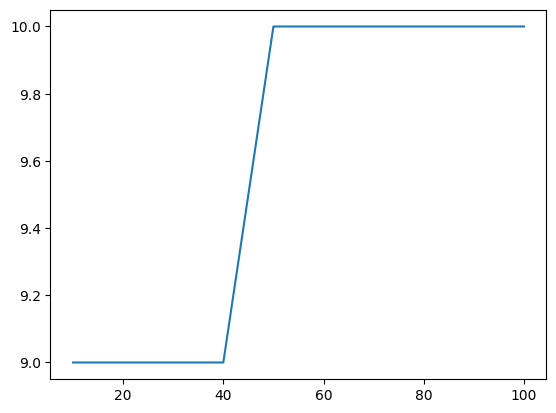

In [10]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

### Question:

* Does the algorithm converge all the time?
* What happens if you change the default parameters?
* How does your algorithm compare to other algorithms on the leader board?
* Search the literature: What type of other algorithms are used to solve this problem (e.g. actor-critic)? (Preset policies do not matter.)
* Remove the activation functions from your network. This results in a linear approximator. How do the results change?

### Question 1
This implementation confirms, what the course and the literature already suggested: Conversion is challenging, hence the answer is no, it does not converge all the time. DQN can suffer from instability due to the use of nonlinear function approximators like neural networks. Techniques such as experience replay and fixed target networks have been introduced to address these issues by providing more stable updates [(Kumar, 2020)](https://arxiv.org/pdf/2006.04938). So convergence has successfully been improved, but the problem can't be fully mitigated. 

### Question 2
Similarly to the first question, this implementation confirms, what the course and the literature already suggested: The algorithm is very sensitive to hyperparameters. These predominantly include the learning rate, discount factor, and the strategy for updating the target network. After playing around with the hyperparameters above I can confirm this - The network often does not reach a satisfactory result at all, even after 1000 Episodes. Finding the optimal set of hyperparameters can be a trial-and-error process that requires extensive experimentation and can significantly impact the learning outcomes and computational efficiency [(Özalp et al., 2020)](https://d1wqtxts1xzle7.cloudfront.net/78483763/978-3-030-49724-8_10-libre.pdf?1641868480=&response-content-disposition=inline%3B+filename%3DA_Review_of_Deep_Reinforcement_Learning.pdf&Expires=1714573494&Signature=EuwWbpiqq-Pd33aZSp~vhq9UTd44MkWSs~hZyfvbsfZaBzSgSssAIDFPqJjwxy6AIgCqN9R~cPQCNMtdq5cGvs6R9GdYKVhqP-EbV~t2L4Xx66ywXvln4CTSQYSMic02n1FAh4rl3QRhYLQkx8P5WBDs5mvqpTbJQB7okLcgAQMLVr7uTLWBVWeoaVBqdJWoh3g2gziRicrZW34a5GSXuGXL5ph5u7xnYErqOT3FX0eaC71RnK8L1uZ0hc3qYhkoBCkzUdnl2AUXOl1YBTlL48tOmIExlwR76tAUwQcwSehARCPNVvp5RTVmmij0mX~JQnEX0aVuTo95WixBc9CQ5A__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA).

### Question 3
There are several leaderboards available online ([paperswithcode](https://paperswithcode.com/sota/openai-gym-on-cartpole-v1), [GitHub](https://github.com/openai/gym/wiki/Leaderboard), [Hugging Face](https://huggingface.co/spaces/huggingface-projects/Deep-Reinforcement-Learning-Leaderboard)) and I was not sure where to comapare it to. In fact, I believe that many of the papers in the next question offer a far more comprehensive view on model performance. Most of the ones at the different links above allegedly achieve the maximum reward of 500 for cartpole v1 (or other weird values), or 200 for v0, which I don't manage. Contrary to that the papers show precisely how many episodes they take to reach a certain reward and the exact definition of the achievement is much clearer. Either way my implementation is worse, and takes far more than 100 episodes to reach values close to the ones in the leaderboards (Around 250+). Then it does in fact get close to the 200-mark.

<img src="RL-final-1000.png" >

### Question 4
A large number of papers covers the cart pole problem. Hence, many approaches have been tested. They can be grouped by various versions of Q-Learning and Q-Networks (which were predominantly covered in the course), Actor-Critic methods, as well as some distinct approaches. Let's start with the Q-based group, notably tested by Kumar in his 2020 paper "Balancing a CartPole System with Reinforcement Learning":
-   **Q-Learning (QL):** This method is a fundamental reinforcement learning algorithm that learns the value of actions directly from the environment's rewards without needing a model of the environment [(Kumar, 2020)](https://arxiv.org/pdf/2006.04938).

-   **Deep Q Networks (DQN):** DQN extends QL to high-dimensional spaces using deep neural networks for function approximation. It's particularly noted for stabilizing training using experience replay and target networks [(Kumar, 2020)](https://arxiv.org/pdf/2006.04938).

-   **Double-Deep Q-Learning (DDQN):** An extension of DQN that reduces overestimations by decoupling the selection from the evaluation of the action-value function. It shows improved performance over DQN [(Kumar, 2020)](https://arxiv.org/pdf/2006.04938).

-   **Deep Q Networks with Prioritized Experience Replay (DQN+PER):** This variant prioritizes important transitions in experience replay, leading to more efficient learning. It was found to perform the best among the architectures in solving the cart-pole problem within 150 episodes [(Kumar, 2020)](https://arxiv.org/pdf/2006.04938).

- **Double Dueling Deep-Q Network (D3QN):** This approach separates the representation of state values from action advantages, helping to identify the intrinsic worth of states independent of actions and is particularly useful when actions do not significantly affect the environment, thus also serving as a regularization technique in neural networks [(Özalp et al., 2020)](https://d1wqtxts1xzle7.cloudfront.net/78483763/978-3-030-49724-8_10-libre.pdf?1641868480=&response-content-disposition=inline%3B+filename%3DA_Review_of_Deep_Reinforcement_Learning.pdf&Expires=1714573494&Signature=EuwWbpiqq-Pd33aZSp~vhq9UTd44MkWSs~hZyfvbsfZaBzSgSssAIDFPqJjwxy6AIgCqN9R~cPQCNMtdq5cGvs6R9GdYKVhqP-EbV~t2L4Xx66ywXvln4CTSQYSMic02n1FAh4rl3QRhYLQkx8P5WBDs5mvqpTbJQB7okLcgAQMLVr7uTLWBVWeoaVBqdJWoh3g2gziRicrZW34a5GSXuGXL5ph5u7xnYErqOT3FX0eaC71RnK8L1uZ0hc3qYhkoBCkzUdnl2AUXOl1YBTlL48tOmIExlwR76tAUwQcwSehARCPNVvp5RTVmmij0mX~JQnEX0aVuTo95WixBc9CQ5A__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA).

Several algorithms in the realm of actor-critic approaches have been tested:

-   **Asynchronous Advanced Actor Critic (A3C) and Synchronous Advantage Actor-Critic (A2C):** Both methods use multiple copies of the environment to stabilize training in policy gradient methods. A3C runs these copies asynchronously, while A2C uses a synchronous version that tends to be more stable [(Özalp et al., 2020)](https://d1wqtxts1xzle7.cloudfront.net/78483763/978-3-030-49724-8_10-libre.pdf?1641868480=&response-content-disposition=inline%3B+filename%3DA_Review_of_Deep_Reinforcement_Learning.pdf&Expires=1714573494&Signature=EuwWbpiqq-Pd33aZSp~vhq9UTd44MkWSs~hZyfvbsfZaBzSgSssAIDFPqJjwxy6AIgCqN9R~cPQCNMtdq5cGvs6R9GdYKVhqP-EbV~t2L4Xx66ywXvln4CTSQYSMic02n1FAh4rl3QRhYLQkx8P5WBDs5mvqpTbJQB7okLcgAQMLVr7uTLWBVWeoaVBqdJWoh3g2gziRicrZW34a5GSXuGXL5ph5u7xnYErqOT3FX0eaC71RnK8L1uZ0hc3qYhkoBCkzUdnl2AUXOl1YBTlL48tOmIExlwR76tAUwQcwSehARCPNVvp5RTVmmij0mX~JQnEX0aVuTo95WixBc9CQ5A__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA).

-  **Fuzzy Actor-Critic Reinforcement Learning Network (FACRLN):** This approach integrates fuzzy logic with the actor-critic framework, addressing the curse of dimensionality in large-scale or continuous spaces, which is typical in the cart-pole problem. The system uses a fuzzy radial basis function network to approximate both the action value function (actor) and the state value function (critic). This architecture helps in reducing the storage demands and computational load, which is particularly beneficial for real-time applications like cart-pole balancing [(Wang, Cheng, & Yi, 2007)](https://www.sciencedirect.com/science/article/abs/pii/S0020025507001569).

- **Actor-critic framework that incorporates Lyapunov’s method:** This approach tries to guarantee stability. It incorporates Lyapunov’s method from control theory, which guarantees closed-loop stability. By integrating a stability condition as the critic, this framework not only enhances safety, robustness, and reliability but also enables robotic systems to recover to equilibrium despite uncertainties like system variations and external disturbances [(Han, Zhang, Wang, Pan, 2020)](https://arxiv.org/pdf/2004.14288).

-  **Online Actor-Critic Learning with Levenberg-Marquardt Algorithm:** This method improves the efficiency of actor-critic algorithms by integrating the Levenberg-Marquardt optimization technique, which is known for faster convergence. The approach is tested on benchmark tasks including the cart-pole balancing problem, demonstrating effectiveness in enhancing learning speed and performance compared to traditional methods [(Ni et al., 2011)](https://ieeexplore.ieee.org/abstract/document/6033520).

-  **TD-Regularized Actor-Critic Methods:** These methods add regularization to the learning objectives of the actor to stabilize learning by penalizing the temporal difference (TD) error of the critic. This approach ensures that large, potentially destabilizing updates are avoided, particularly in complex tasks like the cart-pole where precise action evaluation is crucial [(Parisi et al., 2018)](https://link.springer.com/content/pdf/10.1007/s10994-019-05788-0.pdf).

Let's look into some alternatives:

-   **Policy Gradient Learning (PGL):** Specifically, the reinforce variant shows effective policy learning by using gradients to update the policy directly, as demonstrated in its application to the cart-pole problem [(Surriani et al., 2021)](https://ieeexplore.ieee.org/abstract/document/9654440).

- **OpenNARS for Applications (ONA):** It targets general machine intelligence and excels in generalization and autonomous transfer learning, unlike typical reinforcement learning systems. In experiments, ONA maintained high performance levels even when control directions in a cart-pole task were inverted and reverted, demonstrating superior knowledge retention and application compared to other models like Actor-Critic and Q-Learner [(Özalp et al., 2020)](https://d1wqtxts1xzle7.cloudfront.net/78483763/978-3-030-49724-8_10-libre.pdf?1641868480=&response-content-disposition=inline%3B+filename%3DA_Review_of_Deep_Reinforcement_Learning.pdf&Expires=1714573494&Signature=EuwWbpiqq-Pd33aZSp~vhq9UTd44MkWSs~hZyfvbsfZaBzSgSssAIDFPqJjwxy6AIgCqN9R~cPQCNMtdq5cGvs6R9GdYKVhqP-EbV~t2L4Xx66ywXvln4CTSQYSMic02n1FAh4rl3QRhYLQkx8P5WBDs5mvqpTbJQB7okLcgAQMLVr7uTLWBVWeoaVBqdJWoh3g2gziRicrZW34a5GSXuGXL5ph5u7xnYErqOT3FX0eaC71RnK8L1uZ0hc3qYhkoBCkzUdnl2AUXOl1YBTlL48tOmIExlwR76tAUwQcwSehARCPNVvp5RTVmmij0mX~JQnEX0aVuTo95WixBc9CQ5A__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA).

### Question 5

In [7]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 10           # 5
        self.max_ep = 100        # 100
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'linear'), (128, 'linear'), (2, 'linear')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
EValuation at episode: 10 -> 10.0
Episode Id: 10 Return during training: 16.0
EValuation at episode: 20 -> 13.0
Episode Id: 20 Return during training: 12.0
EValuation at episode: 30 -> 11.0
Episode Id: 30 Return during training: 11.0
EValuation at episode: 40 -> 11.0
Episode Id: 40 Return during training: 10.0
EValuation at episode: 50 -> 10.0
Episode Id: 50 Return during training: 10.0
EValuation at episode: 60 -> 10.0
Episode Id: 60 Return during training: 10.0
EValuation at episode: 70 -> 10.0
Episode Id: 70 Return during training: 10.0
EValuation at episode: 80 -> 10.0
Episode Id: 80 Return during training: 10.0
EValuation at episode: 90 -> 10.0
Episode Id: 90 Return during training: 10.0
EValuation at episode: 100 -> 10.0
Training was finished.


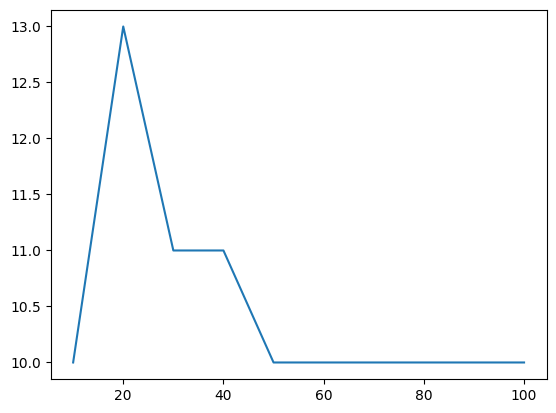

In [8]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

The linear algorithm does not "learn". In my case it fluctuates around 10 for the full number of episodes (Tested until 1000 episodes), whereas the non-linear version does expierence a gradual increase of rewards until close to 200 after a large number of episodes.